# Example: Single Cell Gene Expression Trajectories

[Packer et al.](https://www.science.org/doi/10.1126/science.aax1971) demonstrated
how single-cell RNA sequencing uncovers trajectories relating to the cell 
development in the *C. elegans*. These trajectories can be seen as a branching
structure that we can detect with FLASC. In this notebook, we show how HDBSCAN\*
and FLASC can be applied on this data set.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
from flasc import FLASC
from umap import UMAP
import matplotlib.collections as mc
from sklearn.preprocessing import normalize
from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

## Data

The dataset and pre-processing is described in the 
[documentation of Monocle 3](https://cole-trapnell-lab.github.io/monocle3/docs/trajectories/).
In essence, different measuring batches are aligned, so that measuring noise is
reduced. Then, the first 50 PCA coordinates are taken to reduce noise and focus
on the main patterns. We prepared a file with these 50 PCA coordinates:

In [3]:
df = pd.read_csv('./data/elegans_preprocessed.csv', index_col=0)
df.shape

(6188, 50)

Like [Narayan et al.](https://doi.org/10.1038/s41587-020-00801-7), we visualize the
data using densMap, a variant of UMAP that tries to preserve local densities in 
the projected coordinates. Because HDBSCAN\* does not support the cosine distance
without reverting to an inefficient quadratic implementation, we normalize
the rows so that the Euclidean distance captures the angle between rows. Essentially
computing the Angular distance rather than the Cosine distance.

This projection is used for visualisation purposes only, all analyses are run on
the 50-dimensional feature space.

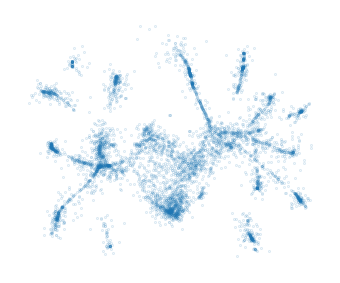

In [5]:
X = normalize(df, norm='l2')
X2 = UMAP(n_neighbors=20, min_dist=0.2, densmap=True).fit_transform(X)

sized_fig()
plt.scatter(X2.T[0], X2.T[1], 0.2, alpha=0.3, marker='.')
frame_off()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/elegans_densmap.png', dpi=300)
plt.show()

## HDBSCAN\*

Running HDBSCAN\* finds 17 clusters containing 36.7% of the data points. The 
clusters appear to correspond to the branches, indicating that the developmental
end-states contain a local density maximum. Many points, however, are classified
as noise, indicating that this segmentation does not capture the structure very 
well.

In [6]:
c = HDBSCAN(min_cluster_size=20).fit(X)

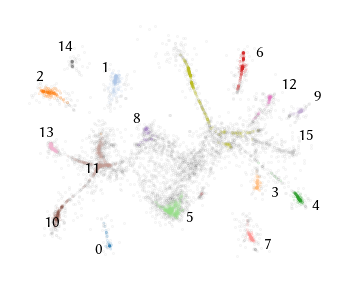

In [7]:
mask = c.labels_ == -1

sized_fig()
plt.scatter(X2[mask, 0], X2[mask, 1], 0.2, color=(0.2, 0.2, 0.2), alpha=0.1, marker='.')
plt.scatter(X2[~mask, 0], X2[~mask, 1], 0.2, c.labels_[~mask], alpha=0.3, vmax=20, cmap='tab20', marker='.')

# Print cluster labels
center = np.mean(X2, axis=0)
centroids = [
    np.mean(X2[c.labels_ == i], axis=0)
    for i in range(c.labels_.max())
]
quadrant = [
    (ctr[0] <= center[0]) + 2 * (ctr[1] <= center[1])
    for ctr in centroids
]
coords = [
    [ctr[0] + 1.2 * (1 if q % 2 == 0 else -1), ctr[1] + 1 * (1 if q < 2 else -1)]
    for q, ctr in zip(quadrant, centroids)
]
for l, ctr in enumerate(coords):
    plt.text(ctr[0], ctr[1], f'{l}')
    
frame_off()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/elegans_clusters.png', dpi=300)
plt.show()

We adapt the CondensedTree plotting logic to colour segments by the selected cluster,
rather than the number of points they contain. (Cell hidden in docs)

In [8]:
from hdbscan.plots import _get_leaves

# Adapt CondensedTree plotting so the segments are coloured by the selected clusters.
def get_plot_data(
    clusterer, tree, leaf_separation=1, log_size=False, max_rectangle_per_icicle=20
):
    CB_LEFT = 0
    CB_RIGHT = 1
    CB_BOTTOM = 2
    CB_TOP = 3
    leaves = _get_leaves(tree._raw_tree)
    last_leaf = tree._raw_tree["parent"].max()
    root = tree._raw_tree["parent"].min()

    # We want to get the x and y coordinates for the start of each cluster
    # Initialize the leaves, since we know where they go, the iterate
    # through everything from the leaves back, setting coords as we go
    if isinstance(leaves, np.int64):
        cluster_x_coords = {leaves: leaf_separation}
    else:
        cluster_x_coords = dict(
            zip(leaves, [leaf_separation * x for x in range(len(leaves))])
        )
    cluster_y_coords = {root: 0.0}

    for cluster in range(last_leaf, root - 1, -1):
        split = tree._raw_tree[["child", "lambda_val"]]
        split = split[
            (tree._raw_tree["parent"] == cluster)
            & (tree._raw_tree["child_size"] > 1)
        ]
        if len(split["child"]) > 1:
            left_child, right_child = split["child"]
            cluster_x_coords[cluster] = np.mean(
                [cluster_x_coords[left_child], cluster_x_coords[right_child]]
            )
            cluster_y_coords[left_child] = split["lambda_val"][0]
            cluster_y_coords[right_child] = split["lambda_val"][1]

    # We use bars to plot the 'icicles', so we need to generate centers, tops,
    # bottoms and widths for each rectangle. We can go through each cluster
    # and do this for each in turn.
    bar_centers = []
    bar_tops = []
    bar_bottoms = []
    bar_widths = []
    bar_labels = []

    cluster_bounds = {}

    scaling = np.sum(
        tree._raw_tree[tree._raw_tree["parent"] == root]["child_size"]
    )

    if log_size:
        scaling = np.log(scaling)

    for c in range(last_leaf, root - 1, -1):
        cluster_bounds[c] = [0, 0, 0, 0]
        c_children = tree._raw_tree[tree._raw_tree["parent"] == c]
        point_children = c_children["child"][c_children["child"] < root]
        if len(point_children) == 0:
            label = 0
        else:
            label = clusterer.labels_[point_children[0]]
        current_size = np.sum(c_children["child_size"])
        current_lambda = cluster_y_coords[c]
        cluster_max_size = current_size
        cluster_max_lambda = c_children["lambda_val"].max()
        cluster_min_size = np.sum(
            c_children[c_children["lambda_val"] == cluster_max_lambda][
                "child_size"
            ]
        )

        if log_size:
            current_size = np.log(current_size)
            cluster_max_size = np.log(cluster_max_size)
            cluster_min_size = np.log(cluster_min_size)

        total_size_change = float(cluster_max_size - cluster_min_size)
        step_size_change = total_size_change / max_rectangle_per_icicle

        cluster_bounds[c][CB_LEFT] = cluster_x_coords[c] * scaling - (
            current_size / 2.0
        )
        cluster_bounds[c][CB_RIGHT] = cluster_x_coords[c] * scaling + (
            current_size / 2.0
        )
        cluster_bounds[c][CB_BOTTOM] = cluster_y_coords[c]
        cluster_bounds[c][CB_TOP] = np.max(c_children["lambda_val"])

        last_step_size = current_size
        last_step_lambda = current_lambda

        for i in np.argsort(c_children["lambda_val"]):
            row = c_children[i]
            if row["lambda_val"] != current_lambda and (
                last_step_size - current_size > step_size_change
                or row["lambda_val"] == cluster_max_lambda
            ):
                bar_centers.append(cluster_x_coords[c] * scaling)
                bar_tops.append(row["lambda_val"] - last_step_lambda)
                bar_bottoms.append(last_step_lambda)
                bar_widths.append(last_step_size)
                bar_labels.append(label)
                last_step_size = current_size
                last_step_lambda = current_lambda
            if log_size:
                exp_size = np.exp(current_size) - row["child_size"]
                # Ensure we don't try to take log of zero
                if exp_size > 0.01:
                    current_size = np.log(
                        np.exp(current_size) - row["child_size"]
                    )
                else:
                    current_size = 0.0
            else:
                current_size -= row["child_size"]
            current_lambda = row["lambda_val"]

    # Finally we need the horizontal lines that occur at cluster splits.
    line_xs = []
    line_ys = []

    for row in tree._raw_tree[tree._raw_tree["child_size"] > 1]:
        parent = row["parent"]
        child = row["child"]
        child_size = row["child_size"]
        if log_size:
            child_size = np.log(child_size)
        sign = np.sign(cluster_x_coords[child] - cluster_x_coords[parent])
        line_xs.append(
            [
                cluster_x_coords[parent] * scaling,
                cluster_x_coords[child] * scaling + sign * (child_size / 2.0),
            ]
        )
        line_ys.append([cluster_y_coords[child], cluster_y_coords[child]])

    return {
        "bar_centers": bar_centers,
        "bar_tops": bar_tops,
        "bar_bottoms": bar_bottoms,
        "bar_widths": bar_widths,
        "bar_labels": bar_labels, 
        "line_xs": line_xs,
        "line_ys": line_ys,
        "cluster_bounds": cluster_bounds,
    }


def plot_icicles(
    c, tree,
    leaf_separation=1,
    selection_palette=None,
    max_rectangles_per_icicle=20,
):
    from matplotlib.patches import Ellipse

    CB_LEFT = 0
    CB_RIGHT = 1
    CB_BOTTOM = 2
    CB_TOP = 3

    plot_data = get_plot_data(
        c, tree,
        leaf_separation=leaf_separation,
        log_size=False,
        max_rectangle_per_icicle=max_rectangles_per_icicle,
    )
    axis = plt.gca()

    axis.bar(
        plot_data["bar_centers"],
        plot_data["bar_tops"],
        bottom=plot_data["bar_bottoms"],
        width=plot_data["bar_widths"],
        color=[selection_palette[l%len(selection_palette)] if l >= 0 else (0.8, 0.8, 0.8) for l in plot_data['bar_labels']],
        align="center",
        linewidth=0,
    )

    drawlines = []
    for xs, ys in zip(plot_data["line_xs"], plot_data["line_ys"]):
        drawlines.append(xs)
        drawlines.append(ys)
    axis.plot(*drawlines, color="black", linewidth=1)

    chosen_clusters = tree._select_clusters()
    plot_range = np.hstack([plot_data["bar_tops"], plot_data["bar_bottoms"]])
    plot_range = plot_range[np.isfinite(plot_range)]
    mean_y_center = np.mean([np.max(plot_range), np.min(plot_range)])
    max_height = np.diff(np.percentile(plot_range, q=[10, 90]))
    for i, c in enumerate(chosen_clusters):
        c_bounds = plot_data["cluster_bounds"][c]
        width = c_bounds[CB_RIGHT] - c_bounds[CB_LEFT]
        height = c_bounds[CB_TOP] - c_bounds[CB_BOTTOM]
        center = (
            np.mean([c_bounds[CB_LEFT], c_bounds[CB_RIGHT]]),
            np.mean([c_bounds[CB_TOP], c_bounds[CB_BOTTOM]]),
        )
        
        if not np.isfinite(center[1]):
            center = (center[0], mean_y_center)
        if not np.isfinite(height):
            height = max_height
        
        axis.annotate(
            str(i),
            xy=center,
            xytext=(center[0], center[1] + 0.7 * height),
            horizontalalignment="center",
            verticalalignment="top",
        )

    axis.set_xticks([])
    for side in ("right", "top", "bottom"):
        axis.spines[side].set_visible(False)
    axis.invert_yaxis()
    axis.set_ylabel("density")

    return axis

The resulting visualisation showhs that the branches are detected as distinct 
subgroups by HDBBSCAN\*. However, the condensed tree does not describe the 
trajectories. In other words, the branching structure or developmental 
trajectories are not captured.

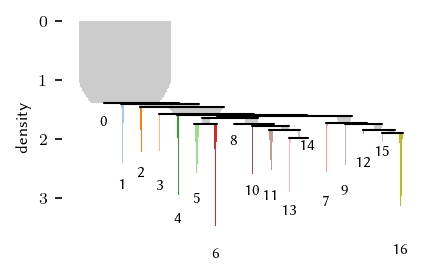

In [9]:
sized_fig()
plot_icicles(
    c, c.condensed_tree_,
    leaf_separation=0.2,
    selection_palette=plt.get_cmap("tab20").colors,
)
plt.subplots_adjust(0.12, 0.1, 0.99, 0.95)
plt.savefig("./images/elegans_cluster_tree.png", dpi=300)
plt.show()

## FLASC

Based on the HDBSCAN\* clustering, we interpret this data to be a single cluster.
To achieve this, we enable the *allow single cluster* flag and set the 
*cluster selection epsilon* to $1/1.4$. This epsilon value will also be the 
threshold for points to be considered as noise. Some points have to be classified
as noise, otherwise they bridge the gaps between the trajectories, hindering 
their detection as branches.

Because all data points are now detected as a single cluster, the number of edges
in the *full* cluster approximation graph is expected to be quite large, as the
cluster spans quite a large density range. Therefore, we use the *core* approximation
graph to detect the branches.

In [10]:
t = 1/1.4
c = FLASC(
    min_samples=5,
    min_cluster_size=20,
    cluster_selection_epsilon=t, 
    allow_single_cluster=True,
    branch_detection_method='core',
).fit(X)
graph = c._cluster_approximation_graphs[0]
mask = c.labels_ != -1
parents = graph.T[0].astype('int')
children = graph.T[1].astype('int')
edges = list(zip(
    zip(X2[children, 0], X2[children, 1]), 
    zip(X2[parents, 0], X2[parents, 1])
))

As expected, FLASC finds the trajectories as branches. Interestingly, the
5-NN graph indicates connectivity that is not obvious from the densMap projection.

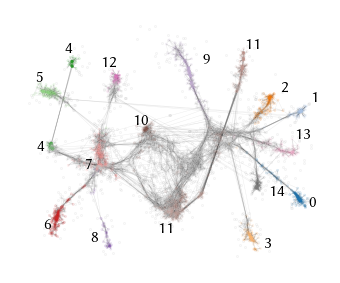

In [27]:
palette = plt.get_cmap('tab20').colors
node_colors = [palette[l%20] for l in c.labels_ if l != -1]

sized_fig()
plt.scatter(X2[~mask, 0], X2[~mask, 1], 0.2, color=(0.2, 0.2, 0.2), alpha=0.1, marker='.')
plt.scatter(X2[mask, 0], X2[mask, 1], 0.2, node_colors, marker='.', alpha=0.3)
lc = mc.LineCollection(edges, linewidths=0.2, color=(0.2, 0.2, 0.2), zorder=-1, alpha=0.1)
plt.gca().add_collection(lc)

# Print cluster labels
center = np.mean(X2, axis=0)
centroids = [
    np.mean(X2[c.labels_ == i], axis=0)
    for i in range(c.labels_.max())
]
quadrant = [
    (ctr[0] <= center[0]) + 2 * (ctr[1] <= center[1])
    for ctr in centroids
]
coords = [
    [ctr[0] + 1.2 * (1 if q % 2 == 0 else -1), ctr[1] + 1 * (1 if q < 2 else -1)]
    for q, ctr in zip(quadrant, centroids)
]
for l, ctr in enumerate(coords):
    if l == 4:
        plt.text(ctr[0] + 1.5, ctr[1] + 3.5, f'{l}')
        plt.text(ctr[0] - 1, ctr[1] - 5, f'{l}')
    elif l == 11:
        plt.text(ctr[0] + 2.5, ctr[1] + 8, f'{l}')
        plt.text(ctr[0] - 5, ctr[1] - 8, f'{l}')
    else:
        plt.text(ctr[0], ctr[1], f'{l}')

frame_off()
plt.subplots_adjust(0, 0, 1, 1)
plt.savefig('./images/elegans_branches.png', dpi=300)
plt.show()

Again, we adapt the CondensedTree code to draw a branch condensed tree coloured
by the selected branches:

In [28]:
from warnings import warn
from hdbscan._hdbscan_tree import compute_stability
from flasc._flasc_tree import epsilon_search, max_lambdas

CB_LEFT = 0
CB_RIGHT = 1
CB_BOTTOM = 2
CB_TOP = 3


class BranchCondensedTree(object):
    def __init__(
        self,
        condensed_tree_array,
        labels, cluster_points,
        branch_selection_method="eom",
        allow_single_branch=False,
        branch_selection_persistence=0,
    ):
        self.num_points = X.shape[0]
        self.labels = labels
        self.cluster_points = cluster_points
        self._raw_tree = condensed_tree_array
        self.branch_selection_method = branch_selection_method
        self.allow_single_branch = allow_single_branch
        self.branch_selection_persistence = branch_selection_persistence

    def get_plot_data(
        self, leaf_separation=1, log_size=False, max_rectangle_per_icicle=20
    ):
        leaves = _get_leaves(self._raw_tree)
        last_leaf = self._raw_tree["parent"].max()
        root = self._raw_tree["parent"].min()

        # We want to get the x and y coordinates for the start of each cluster
        # Initialize the leaves, since we know where they go, the iterate
        # through everything from the leaves back, setting coords as we go
        if isinstance(leaves, np.int64):
            cluster_x_coords = {leaves: leaf_separation}
        else:
            cluster_x_coords = dict(
                zip(leaves, [leaf_separation * x for x in range(len(leaves))])
            )
        cluster_y_coords = {root: 0.0}

        for cluster in range(last_leaf, root - 1, -1):
            split = self._raw_tree[["child", "lambda_val"]]
            split = split[
                (self._raw_tree["parent"] == cluster)
                & (self._raw_tree["child_size"] > 1)
            ]
            if len(split["child"]) > 1:
                left_child, right_child = split["child"]
                cluster_x_coords[cluster] = np.mean(
                    [
                        cluster_x_coords[left_child],
                        cluster_x_coords[right_child],
                    ]
                )
                cluster_y_coords[left_child] = split["lambda_val"][0]
                cluster_y_coords[right_child] = split["lambda_val"][1]

        # We use bars to plot the 'icicles', so we need to generate centers, tops,
        # bottoms and widths for each rectangle. We can go through each cluster
        # and do this for each in turn.
        bar_centers = []
        bar_tops = []
        bar_bottoms = []
        bar_widths = []
        bar_labels = []

        cluster_bounds = {}

        scaling = np.sum(
            self._raw_tree[self._raw_tree["parent"] == root]["child_size"]
        )

        if log_size:
            scaling = np.log(scaling)

        for c in range(last_leaf, root - 1, -1):
            cluster_bounds[c] = [0, 0, 0, 0]

            c_children = self._raw_tree[self._raw_tree["parent"] == c]
            point_children = c_children['child'][c_children['child'] < root]
            if len(point_children) == 0:
                label = 0
            else:
                label = self.labels[self.cluster_points[point_children[0]]]
            current_size = np.sum(c_children["child_size"])
            current_lambda = cluster_y_coords[c]
            cluster_max_size = current_size
            cluster_max_lambda = c_children["lambda_val"].max()
            cluster_min_size = np.sum(
                c_children[c_children["lambda_val"] == cluster_max_lambda][
                    "child_size"
                ]
            )

            if log_size:
                current_size = np.log(current_size)
                cluster_max_size = np.log(cluster_max_size)
                cluster_min_size = np.log(cluster_min_size)

            total_size_change = float(cluster_max_size - cluster_min_size)
            step_size_change = total_size_change / max_rectangle_per_icicle

            cluster_bounds[c][CB_LEFT] = cluster_x_coords[c] * scaling - (
                current_size / 2.0
            )
            cluster_bounds[c][CB_RIGHT] = cluster_x_coords[c] * scaling + (
                current_size / 2.0
            )
            cluster_bounds[c][CB_BOTTOM] = cluster_y_coords[c]
            cluster_bounds[c][CB_TOP] = np.max(c_children["lambda_val"])

            last_step_size = current_size
            last_step_lambda = current_lambda

            for i in np.argsort(c_children["lambda_val"]):
                row = c_children[i]
                if row["lambda_val"] != current_lambda and (
                    last_step_size - current_size > step_size_change
                    or row["lambda_val"] == cluster_max_lambda
                ):
                    bar_centers.append(cluster_x_coords[c] * scaling)
                    bar_tops.append(row["lambda_val"] - last_step_lambda)
                    bar_bottoms.append(last_step_lambda)
                    bar_widths.append(last_step_size)
                    bar_labels.append(label)
                    last_step_size = current_size
                    last_step_lambda = current_lambda
                if log_size:
                    exp_size = np.exp(current_size) - row["child_size"]
                    # Ensure we don't try to take log of zero
                    if exp_size > 0.01:
                        current_size = np.log(
                            np.exp(current_size) - row["child_size"]
                        )
                    else:
                        current_size = 0.0
                else:
                    current_size -= row["child_size"]
                current_lambda = row["lambda_val"]

        # Finally we need the horizontal lines that occur at cluster splits.
        line_xs = []
        line_ys = []

        for row in self._raw_tree[self._raw_tree["child_size"] > 1]:
            parent = row["parent"]
            child = row["child"]
            child_size = row["child_size"]
            if log_size:
                child_size = np.log(child_size)
            sign = np.sign(cluster_x_coords[child] - cluster_x_coords[parent])
            line_xs.append(
                [
                    cluster_x_coords[parent] * scaling,
                    cluster_x_coords[child] * scaling
                    + sign * (child_size / 2.0),
                ]
            )
            line_ys.append([cluster_y_coords[child], cluster_y_coords[child]])

        return {
            "bar_centers": bar_centers,
            "bar_tops": bar_tops,
            "bar_bottoms": bar_bottoms,
            "bar_widths": bar_widths,
            "bar_labels": bar_labels,
            "line_xs": line_xs,
            "line_ys": line_ys,
            "cluster_bounds": cluster_bounds,
        }

    def _select_clusters(self):
        selected = None
        if self.branch_selection_method == "eom":
            stability = compute_stability(self._raw_tree)
            if self.allow_single_branch:
                node_list = sorted(stability.keys(), reverse=True)
            else:
                node_list = sorted(stability.keys(), reverse=True)[:-1]
            cluster_tree = self._raw_tree[self._raw_tree["child_size"] > 1]
            is_cluster = {cluster: True for cluster in node_list}

            for node in node_list:
                child_selection = cluster_tree["parent"] == node
                subtree_stability = np.sum(
                    [
                        stability[child]
                        for child in cluster_tree["child"][child_selection]
                    ]
                )

                if subtree_stability > stability[node]:
                    is_cluster[node] = False
                    stability[node] = subtree_stability
                else:
                    for sub_node in _bfs_from_cluster_tree(cluster_tree, node):
                        if sub_node != node:
                            is_cluster[sub_node] = False

            selected = sorted(
                [cluster for cluster in is_cluster if is_cluster[cluster]]
            )
        else:
            selected = _get_leaves(self._raw_tree)
        
        if self.branch_selection_persistence != 0.0:
            deaths = max_lambdas(self._raw_tree, self.num_points)

            selected = epsilon_search(
                selected, 
                cluster_tree.copy(), 
                self.branch_selection_persistence, 
                deaths
            )
        return selected

    def plot(
        self,
        leaf_separation=1,
        select_clusters=False,
        label_clusters=False,
        selection_palette=None,
        axis=None,
        colorbar=True,
        log_size=False,
        max_rectangles_per_icicle=20,
    ):
        plot_data = self.get_plot_data(
            leaf_separation=leaf_separation,
            log_size=log_size,
            max_rectangle_per_icicle=max_rectangles_per_icicle,
        )

        if axis is None:
            axis = plt.gca()

        axis.bar(
            plot_data["bar_centers"],
            plot_data["bar_tops"],
            bottom=plot_data["bar_bottoms"],
            width=plot_data["bar_widths"],
            color=[selection_palette[l%len(selection_palette)] if l >= 0 else (0.8, 0.8, 0.8) for l in plot_data['bar_labels']],
            align="center",
            linewidth=0,
        )

        drawlines = []
        for xs, ys in zip(plot_data["line_xs"], plot_data["line_ys"]):
            drawlines.append(xs)
            drawlines.append(ys)
        axis.plot(*drawlines, color="black", linewidth=1)
        # for xs, ys in zip(plot_data['line_xs'], plot_data['line_ys']):
        #     axis.plot(xs, ys, color='black', linewidth=1)

        if select_clusters:
            try:
                from matplotlib.patches import Ellipse
            except ImportError:
                raise ImportError(
                    "You must have matplotlib.patches available to plot selected clusters."
                )

            chosen_clusters = self._select_clusters()

            # Extract the chosen cluster bounds. If enough duplicate data points exist in the
            # data the lambda value might be infinite. This breaks labeling and highlighting
            # the chosen clusters.
            cluster_bounds = np.array(
                [plot_data["cluster_bounds"][c] for c in chosen_clusters]
            )
            if not np.isfinite(cluster_bounds).all():
                warn(
                    "Infinite lambda values encountered in chosen clusters."
                    " This might be due to duplicates in the data."
                )

            # Extract the plot range of the y-axis and set default center and height values for ellipses.
            # Extremly dense clusters might result in near infinite lambda values. Setting max_height
            # based on the percentile should alleviate the impact on plotting.
            plot_range = np.hstack(
                [plot_data["bar_tops"], plot_data["bar_bottoms"]]
            )
            plot_range = plot_range[np.isfinite(plot_range)]
            mean_y_center = np.mean([np.max(plot_range), np.min(plot_range)])
            max_height = np.diff(np.percentile(plot_range, q=[10, 90]))

            for i, c in enumerate(chosen_clusters):
                c_bounds = plot_data["cluster_bounds"][c]
                width = c_bounds[CB_RIGHT] - c_bounds[CB_LEFT]
                height = c_bounds[CB_TOP] - c_bounds[CB_BOTTOM]
                center = (
                    np.mean([c_bounds[CB_LEFT], c_bounds[CB_RIGHT]]),
                    np.mean([c_bounds[CB_TOP], c_bounds[CB_BOTTOM]]),
                )

                # Set center and height to default values if necessary
                if not np.isfinite(center[1]):
                    center = (center[0], mean_y_center)
                if not np.isfinite(height):
                    height = max_height

                if label_clusters:
                    axis.annotate(
                        str(i),
                        xy=center,
                        xytext=(
                            center[0],
                            center[1] + 0.7 * height,
                        ),
                        horizontalalignment="center",
                        verticalalignment="top",
                    )

        axis.set_xticks([])
        for side in ("right", "top", "bottom"):
            axis.spines[side].set_visible(False)
        axis.invert_yaxis()
        axis.set_ylabel("$\lambda$ value")

        return axis
    

def _bfs_from_cluster_tree(tree, bfs_root):
    """
    Perform a breadth first search on a tree in condensed tree format
    """

    result = []
    to_process = [bfs_root]

    while to_process:
        result.extend(to_process)
        to_process = tree['child'][np.in1d(tree['parent'], to_process)].tolist()

    return result

def _recurse_leaf_dfs(cluster_tree, current_node):
    children = cluster_tree[cluster_tree['parent'] == current_node]['child']
    if len(children) == 0:
        return [current_node,]
    else:
        return sum([_recurse_leaf_dfs(cluster_tree, child) for child in children], [])

def _get_leaves(condensed_tree):
    cluster_tree = condensed_tree[condensed_tree['child_size'] > 1]
    if cluster_tree.shape[0] == 0:
        # Return the only cluster, the root
        return [condensed_tree['parent'].min()]

    root = cluster_tree['parent'].min()
    return _recurse_leaf_dfs(cluster_tree, root)

The resulting branch condensed hierarchy better describes the cluster's shape.
However, it only contains the most-eccentric connections between the branches.

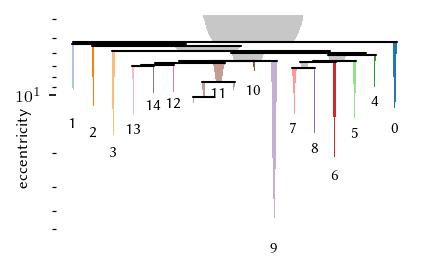

In [29]:
sized_fig()
BranchCondensedTree(
    c._cluster_condensed_trees[0],
    c.labels_,
    c.cluster_points_[0],
    c.branch_selection_method,
    c.allow_single_branch,
    c.branch_selection_persistence
).plot(
    colorbar=False,
    leaf_separation=0.2,
    select_clusters=True,
    label_clusters=True,
    selection_palette=palette
)
plt.yscale('log')
# plt.ylim(0.2, 0)
# plt.yticks([0, .1, .2, .3])
plt.ylabel('eccentricity', labelpad=-7, y=0.4)
plt.subplots_adjust(0.13, 0.07, 1, 0.95)
plt.savefig('./images/elegans_branch_tree.png', dpi=300)
plt.show()